In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
# directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/652 [00:00<?, ?it/s]

In [35]:
all_folders["unique_id"].unique()

array(['24_20220426', '241_20230403', '247_20230422', '33_20230221',
       '46_20230301'], dtype=object)

In [5]:
plates = [
    "241_20230403",
    "247_20230422",
    # '24_20220426'
]
folders = all_folders.loc[all_folders["unique_id"] == "241_20230403"]
directory = directory_targ

In [23]:
select = folders.loc[folders["folder"] == "20230408_0406_Plate14"]

In [9]:
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 200
exp.load_light(folders.iloc[:], suffix="_width")

In [18]:
len(folders)

132

In [9]:
i = 0
folder_list = list(select["folder"])
folder_list.sort()
directory_name = folder_list[i]
print(directory_name)
run_back_sub(directory, directory_name)
path_snap = os.path.join(directory, directory_name)
path_tile = os.path.join(path_snap, "Img/TileConfiguration.txt.registered")
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = os.path.join(path_snap, "Img/TileConfiguration.registered.txt")
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
dirName = path_snap + "/Analysis"
try:
    os.mkdir(path_snap + "/Analysis")
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")
t = time()
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
name = tileconfig[0][0]
imname = "/Img3/" + name.split("/")[-1]
im = imageio.imread(directory + directory_name + imname)
dim = (
    int(np.max(ys) - np.min(ys)) + max(im.shape),
    int(np.max(xs) - np.min(xs)) + max(im.shape),
)
ims = []
skel = np.zeros(dim, dtype=np.uint8)
params = [30]

20230408_0406_Plate14


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


Directory  /scratch-shared/amftrack/stitch_temp2/20230408_0406_Plate14/Analysis  already exists


/projects/0/einf914/data//20230408_0406_Plate14//Img2/Img_r06_c09.tif


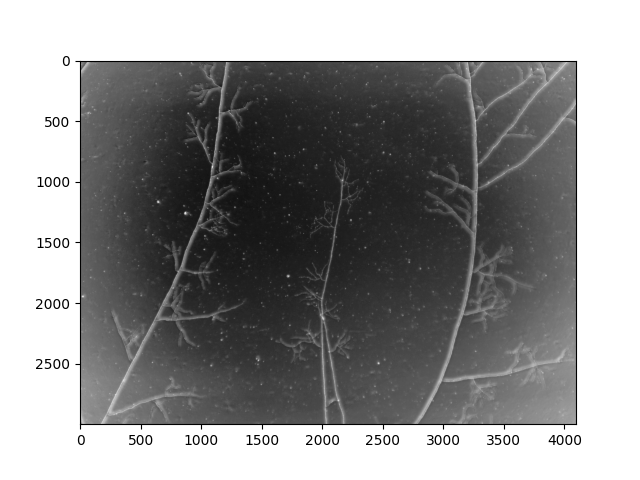

In [32]:
j = 61

for index, name in enumerate(tileconfig[0][j : j + 1]):
    # for index, name in enumerate(list_debug):
    print(name)
    imname = "/Img3/" + name.split("/")[-1]
    im = imageio.imread(directory + directory_name + imname)
    imname2 = "/Img/" + name.split("/")[-1]
    im2 = imageio.imread(directory + directory_name + imname2)
    bowled2 = bowler_hat(-im2, 32, params)
    im[bowled2 <= 0.09] = np.maximum(im[bowled2 <= 0.09], 250)
    fig, ax = plt.subplots()
    ax.imshow(im2, cmap="Greys")
    # shape = im.shape
    # print("segmenting")
    # segmented = extract_skel_new_prince(im, [hyph_width], perc_low, perc_high)
    # # low = np.percentile(-im+255, perc_low)
    # # high = np.percentile(-im+255, perc_high)
    # # segmented = filters.apply_hysteresis_threshold(-im+255, low, high)
    # boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
    #     tileconfig[2][index][1] - np.min(ys)
    # )
    # skel[
    #     boundaries[1] : boundaries[1] + shape[0],
    #     boundaries[0] : boundaries[0] + shape[1],
    # ] += segmented

In [33]:
from amftrack.pipeline.functions.image_processing.extract_skel import *

hyph_width = 30
perc_low = 85
perc_high = 99.5
minlow = 10
minhigh = 70
bowled = bowler_hat(-im.astype(np.uint8), 32, params)
filename = time_ns()
place_save = temp_path
to_smooth = np.minimum(bowled * 255, 255 - im)
# to_smooth = 255-im
imtransformed_path = f"{place_save}/{filename}.tif"
imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
path_anis = pastis_path
args = [0.1, 7, 0.9, 10, 50]
command = [path_anis, imtransformed_path] + args
command = [str(elem) for elem in command]
print("anis filtering")
process = subprocess.run(command, cwd=place_save, stdout=subprocess.DEVNULL)
foldname = f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
imname = foldname + f"/{foldname}it{args[4]}.tif"
path_modif = place_save + "/" + imname
try:
    im2 = imageio.imread(path_modif)
except:
    im2 = to_smooth.astype(np.uint8)
print("image_reading")
shutil.rmtree(os.path.join(place_save, foldname))
low = max(minlow, np.percentile(im2, perc_low))
high = max(minhigh, np.percentile(im2, perc_high))
transformed = im2
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
dilated = remove_holes(hyst)
dilated = dilated.astype(np.uint8)
connected = remove_component(dilated)

anis filtering
image_reading


In [18]:
hyph_width = 10
perc_low = 85
perc_high = 99.5
minlow = 10
minhigh = 70
connected = extract_skel_new_prince(
    im, [hyph_width], perc_low, perc_high, minlow, minhigh
)

anis filtering
image_reading


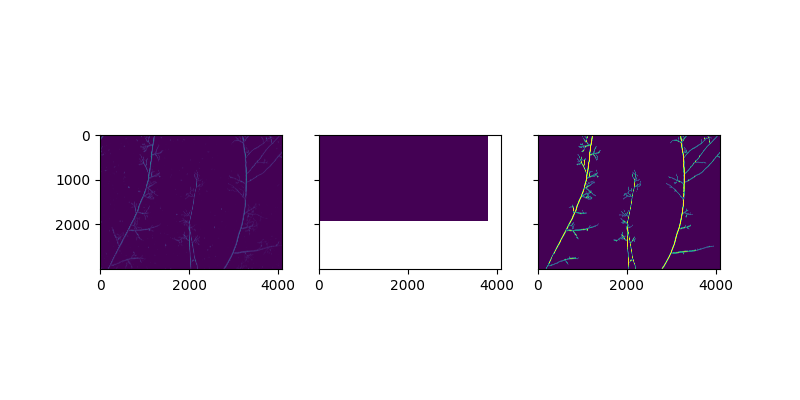

In [34]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(im2)
ax[1].imshow(im3)
ax[2].imshow(connected)

In [26]:
# select = all_folders.loc[(all_folders['folder'].isin([ '20210929_0308_Plate21',
#  '20210929_0912_Plate21']))]
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 2
start = 0

# start = choice(range(len(folder_list)))
finish = start + 1
for folder in folder_list[start:finish]:
    # print(folder)
    path_snap = directory + folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton_realigned_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    #     im = imageio.imread(path_snap+'/StitchedImage.tif')
    #     im = cv2.resize(im,(skel.shape[1],skel.shape[0]))
    #     M = np.float32([
    # 	[1, 0, 0],
    # 	[0, 1, -117]])
    #     im = cv2.warpAffine(im,M,(im.shape[1], im.shape[0]))
    ims.append(im)

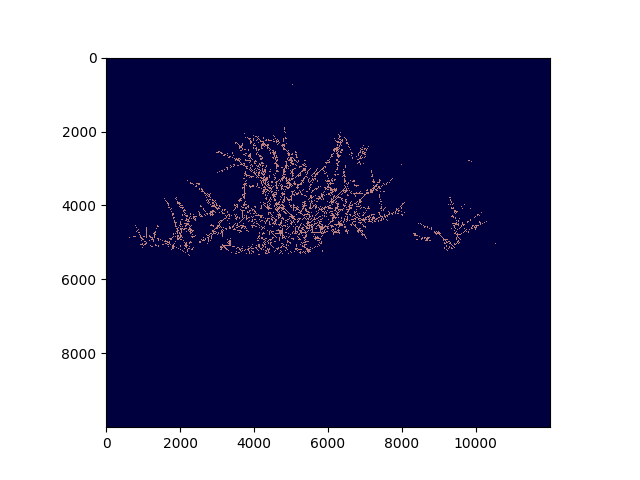

In [27]:
plt.close("all")
start = 0
finish = start + 1
for i in range(start, finish):
    plot_t_tp1([], [], None, None, skels[i], skels[i])

In [21]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
